# Get Spatial data
This section is somewhat techincal. The specifics are not necessary to understand the analysis. 

In [37]:
# Import some packages
import warnings
import pandas as pd
import osmnx as ox 
import networkx as nx
import pandana as pa
import matplotlib.pyplot as plt
import utils.data_processing as dp
import utils.accessibility_analysis as aa
import geopandas
import numpy as np
from shapely.geometry import Point
import seaborn as sns
import folium

# Some configs
warnings.filterwarnings('ignore')
ox.config(log_console=True, use_cache=True)
pd.set_option('display.max_columns', 200)
#%matplotlib inline

## Set bounding box

A bounding box of lattitude and longitude coordinates describes a rectangular geospatial region. For this report, I've chosen a bounding box that includes Wellington City and some of Lower Hutt. This selection is important since only the entities *within* the bounding box are used in the analysis. The visual tool [here](http://boundingbox.klokantech.com/) is useful for obtaining the bounding box coordinates from a user-defined rectangle on the map. 

A key technical point is that [bounding box conventions do vary](https://wiki.openstreetmap.org/wiki/Bounding_Box
):
- The general definition uses (min Longitude , min Latitude , max Longitude , max Latitude), or  (W, S, E, N) 
- Pandana and Overpass use (S, W, N, E).

![](assets/bounding_box_selection.png)


In [38]:
# Define bounding box (W, S, E, N) for the area of Wellington we're interested in
# Copied from http://boundingbox.klokantech.com/
general_bbox = [174.57,-41.4552,174.84,-41.1527]

# Separate out the bounding box list into 4 vertices. 
south = general_bbox[1]
west = general_bbox[0]
north = general_bbox[3]
east = general_bbox[2]

# Set OSM bounding box
osm_bbox = [south, west, north, east]

## Create Query
The following section creates a query to get fuel station data from Open Street Maps. The tags list can also be amended to get other amenities. The full list is [here](https://wiki.openstreetmap.org/wiki/Key:amenity). For example, we can easily get data for cafes and restaurants by adding these to the tags list.  

The Overpass API query is not very easy to read but the main components are: 
- The bounding box: the area where we want the search performed. 
- Data Primitives: ways, nodes, tags, relations.

The data primities of OSM have an intrinsic hierarchy with nodes being the root primitive. 
- Nodes: Single point with explicit [lat, lon] coordinates. Root primitive
- Ways: Collection of nodes that defines a polygon (e.g. a building) or polyline (e.g. a road). 
- Relations: Represent the relationship of existing nodes and ways
- Tags: Metadata stored as key-value pairs. 

The main primitives used in this report are nodes and tags. The nodes give the geolocation while we use the tags to filter specifically for fuel station nodes. More information about the entities of Open Street Maps can be found [here](https://en.wikipedia.org/wiki/OpenStreetMap#Operation). 

## Getting data from Overpass 
Getting data from Open Street Map is fairly simple via the Overpass API. All you need to do is construct the search query and reshape the result JSON into your data structure of choice. 
Given that pubs, alcohol shops and bars can be described as both nodes and ways, we need two queries to extract the data. Process ways as polygons and derive centroids; process nodes as POIs. Given that OSM contributors aren't choosing nodes or ways with preference, we need to include both in the analysis. 


In [39]:
# What types of entitities do we want to get? Currently restricted to amenities
tags = ['alcohol', 'pub', 'bar']
objects = ['node'] # like way, node, relation
entities = ['shop', 'amenity']
# Generate the query string
compactOverpassQLstring = dp.generate_overpass_query(tags, objects, osm_bbox, entities)

# Store nodes as df
osmdf_nodes = dp.get_osm_data(compactOverpassQLstring, osm_bbox)
alcohol_nodes = (osmdf_nodes[['id', 'lat', 'lon', 'name', 'amenity', 'type']]
                 .sort_values(['lat', 'lon'])
                 .reset_index()
                 .drop(columns='index'))
alcohol_nodes.head(5)

,id,lat,lon,name,amenity,type
0,4522166458,-41.328972,174.811298,Cook Strait Bar,bar,node
1,623879839,-41.325184,174.820872,The Strathmore Local,pub,node
2,625080280,-41.319506,174.794358,Bay 66,pub,node
3,627273501,-41.318117,174.794450,Kilbirnie Tavern,pub,node
4,627273500,-41.318011,174.794874,Corner Bar,pub,node


In [40]:
reload(dp)
# What types of entitities do we want to get? 
objects = ['way'] # like way, node, relation

# Generate the query string
compactOverpassQLstring = dp.generate_overpass_query(tags, objects, osm_bbox, entities)

# Store ways as df
osmdf_ways = dp.get_osm_data(compactOverpassQLstring, osm_bbox)
alcohol_ways = osmdf_ways[['id', 'lat', 'lon', 'name', 'amenity', 'type', 'nodes']]
alcohol_ways.head(5)

,id,lat,lon,name,amenity,type,nodes
0,62153738,NaN,NaN,Mac's Brewery,pub,way,"[775428527, 775428528, 775428657, 775428658, 2..."
1,133129214,NaN,NaN,Thistle Inn,bar,way,"[1464807182, 1464807184, 1464807179, 146480718..."
2,251574160,NaN,NaN,Southern Cross,bar,way,"[2577788320, 3003896629, 3003896628, 257778832..."
3,251574164,NaN,NaN,Havana Bar,bar,way,"[2577788337, 2577788338, 2577788339, 257778834..."
4,252076932,NaN,NaN,Laundry,bar,way,"[2581963186, 2581963187, 2581963188, 289473992..."


In [41]:
osmdf_ways_clean = dp.extend_ways_to_node_view(alcohol_ways)
osmdf_ways_clean.fillna('No Name', inplace=True)

In [42]:
# Doesn't get the pubs, bars and shops without a name. Need to do a fillna()
# And check that the NAs are legit businesses
alcohol_ways_nodes = (osmdf_ways_clean
                      .merge(alcohol_ways[['id', 'amenity', 'name']]
                             .drop_duplicates(), left_on='way_id', right_on='id')
                      .groupby(['way_id', 'name', 'amenity', 'type'])
                      .agg({'lat': 'mean', 'lon': 'mean' })
                      .reset_index()
                      .rename(columns={'way_id': 'id'}))

In [43]:
alcohol_pois = pd.concat([alcohol_nodes, alcohol_ways_nodes])

In [44]:
map_alcohol = folium.Map(location=[-41.29, 174.8], zoom_start = 11)

for each in alcohol_pois.iterrows():
    folium.Marker(location = [each[1]['lat'],each[1]['lon']]).add_to(map_alcohol)
#    folium.Popup(each[1]['name']).add_to(map_alcohol)

map_alcohol

# Get parks data

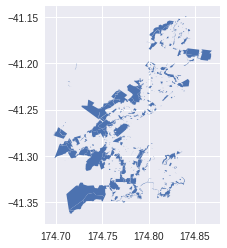

In [45]:
def getXY(pt):
    return (pt.x, pt.y)

wcc_parks = geopandas.read_file('zip://./data/WCC_Parks_and_Reserves.zip')
wcc_parks['centroid'] = wcc_parks.centroid
x,y = [list(t) for t in zip(*map(getXY, wcc_parks['centroid']))]
park_pois = pd.DataFrame({'lat': x, 'lon': y})


wcc_parks.plot()

In [46]:
# Generate random sample data
df = pd.DataFrame({'lon': np.random.normal(np.mean([west, east]), 0.05, size=(1000)),
                   'lat': np.random.normal(np.mean([south, north]), 0.07, size=(1000))})

# create Geometry series with lat / longitude
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]

df = df.drop(['lon', 'lat'], axis = 1)

# Create GeoDataFrame
points = geopandas.GeoDataFrame(df, crs=None, geometry=geometry)

# Find intersecting points with park polygons
intersecting_points = []

for i  in range(len(wcc_parks)):
    x = points[points.within(wcc_parks['geometry'].ix[i])]
    if len(x) > 0:
        intersecting_points.append(x)
        
intersecting_points = pd.concat(intersecting_points)

# Create lat, lon POIS dataframe
x,y = [list(t) for t in zip(*map(getXY, intersecting_points['geometry']))]
park_set_pois = pd.DataFrame({'lon': x, 'lat': y})

# Accessibility analysis
The above analyses only consider the fuel stations and quantify implicit interactions (via road distance) between them. But we get the real benefit of spatial analyses when we consider interactions between the fuel stations and other entities - from humans to other businesses. One type of interaction with general entities is accessibility. Simple accessibility analyses convert the base geography of the region into a point grid, and compute distances between every point and the POIS. 

Accessibility is a core analysis in urban planning. Some examples [here](https://www.slideshare.net/DimkaG/transitaccess-27460698). There are even tools which score regions with scores based on accessibility
e.g. [WalkScore](https://www.walkscore.com/). 

## Calculating accessibility
Here, we consider accessibility as the driving distance in meters from each grid point (also referred to as nodes) to the nearest POIS: a fuel station. To do a visual acessibility analysis we need to: 
- Break up the map into grid of points (I) 
- Calculate the distance from each point to the nth nearest POIS (II) 
- Visualise distance as a heatmap (III)

All the above steps are carried out by the Python package Pandana. Of the above steps, I has a few sub-steps. These are: 
- Download OSM data within the specified bounding box 
- Convert map to point grid. Remember, this is easy since all OSM streets and roads are *ways* which are simply a collection of nodes / points. 
- Store points data in a convenient data structure: a Pandas dataframe 
- Filter out poorly connected points

In [47]:
# Set some parameters for accessibility analysis
n = 1 # nth closest nodes to fuel station. n = 1 means the closest.
distance = 5000.0 # distance bound for accessibility calculation; impedance limit.
num_pois = 10

# Plotting parameters
bbox_aspect_ratio = (osm_bbox[2] - osm_bbox[0]) / (osm_bbox[3] - osm_bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}
#plot_kwargs = {'s':5, 
#               'alpha':0.9, 
#               'cmap':'viridis_r', 
#               'edgecolor':'none'}

bmap_kwargs={'epsg':'2193','resolution':'f'}
plot_kwargs={'cmap':'viridis_r','s':4,'edgecolor':'none'}

In [48]:
# Generate accessibility network
network = aa.get_pandana_network(osm_bbox, impedance=distance)
alco_accessibility = aa.get_accessibility(network, alcohol_pois, distance=distance, num_pois=num_pois)
park_accessibility = aa.get_accessibility(network, park_set_pois, distance=distance, num_pois=num_pois)

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"cycleway|footway|path|pedestrian|steps|track|proposed|construction|bridleway|abandoned|platform|raceway|service"]["motor_vehicle"!~"no"]["motorcar"!~"no"]["service"!~"parking|parking_aisle|driveway|emergency_access"](-41.45520000,174.57000000,-41.15270000,174.84000000);>;);out;'}"
Downloaded 4,471.2KB from www.overpass-api.de in 5.13 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 5.30 seconds
Returning OSM data with 37,690 nodes and 3,222 ways...
Edge node pairs completed. Took 6.28 seconds
Returning processed graph with 3,277 nodes and 4,172 edges...
Completed OSM data download and Pandana node and edge table creation in 13.40 seconds


## Accessibility to alcohol

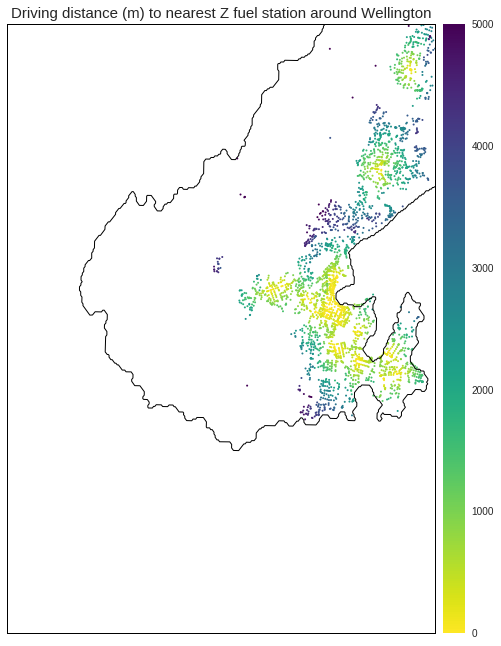

In [49]:
# Plot driving accessibility for Z stations
aa.plot_accessibility(network, alco_accessibility[n], osm_bbox, 
                      fig_kwargs=fig_kwargs, plot_kwargs=plot_kwargs, bmap_kwargs=bmap_kwargs)

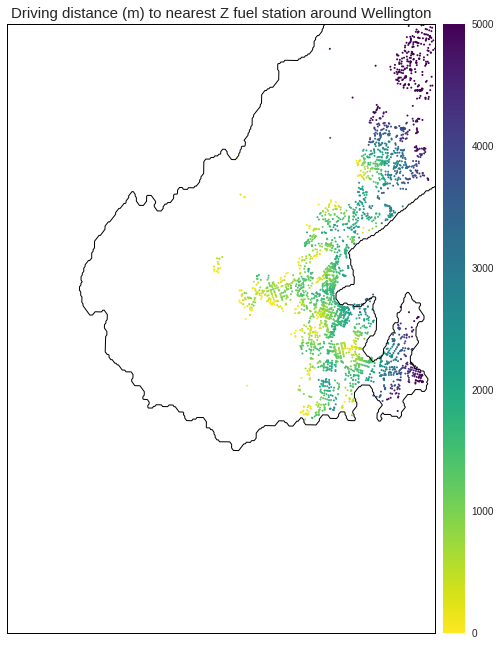

In [50]:
# Plot driving accessibility for Z stations
aa.plot_accessibility(network, park_accessibility[n], osm_bbox, 
                      fig_kwargs=fig_kwargs, plot_kwargs=plot_kwargs, bmap_kwargs=bmap_kwargs)

## Differential accessbility: playgrounds vs. alcohol

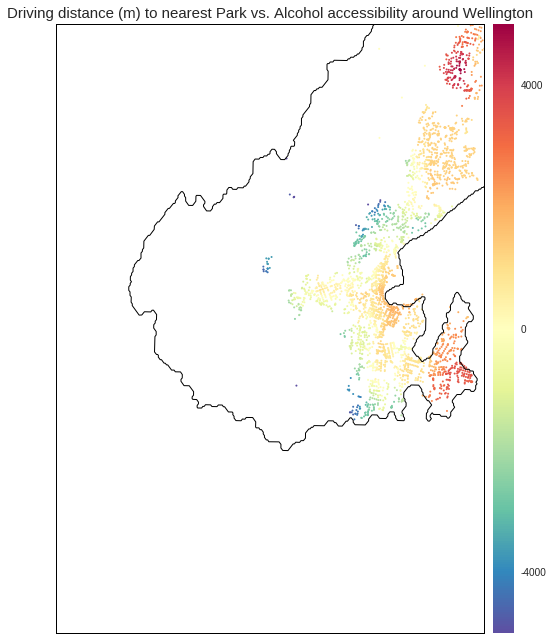

In [51]:
# Plotting parameters
diff_kwargs = plot_kwargs.copy()
diff_kwargs['cmap'] = 'Spectral_r'
bmap_kwargs={'epsg':'2193','resolution':'f'}
cbar_kwargs = {'location': 'right', 
               'format': '%d', 
               'label':'',
               'ticks': [-4000, 0, 4000]}

# Plot differential coverage
diff_accessibility = park_accessibility[1] - alco_accessibility[1]
bmap = aa.plot_accessibility(network, diff_accessibility, osm_bbox, 
                      amenity_type="Park vs. Alcohol accessibility",
                      fig_kwargs=fig_kwargs, plot_kwargs=diff_kwargs, 
                      bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)


The convenience of the common accessibility nodes can help us approximate an average accessibility to a Z / BP station for the Wellington region. The histograms plot the distance to the nearest Z / BP station. The mean and median show two quite interesting points:
- There are more nodes that are more than 5km from a Z station. These "inaccessible" nodes increase the mean accessibility to a Z station for the region. The difference in the mean accessibility of Z and BP are fairly close.  Z stations are only closer by 100 m. 
- If the inaccessible nodes are not considered as strongly (i.e. using the median), Z stations are more accessible by 200m. 

While Z does better for the covered regions, the regions that aren't covered by Z reduce the average accessibility.  

In [52]:
# Put accessibility data together
nearest_park = park_accessibility[1].reset_index(name='distance')
nearest_alco = alco_accessibility[1].reset_index(name='distance')
nearest_park['type'] = 'Park'
nearest_alco['type'] = 'Alcohol'

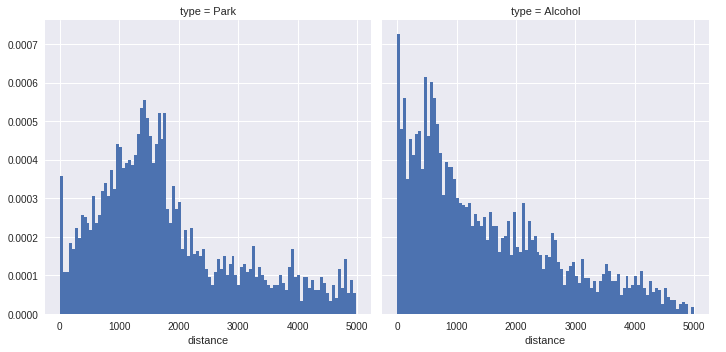

In [53]:
# Plot Z and BP accessibility together
nearest_p = pd.concat([nearest_park, nearest_alco])
nearest_p = nearest_p.query('distance < 5000')
g = sns.FacetGrid(col='type', data=nearest_p, size=5)
g.map(plt.hist, 'distance', normed=True, bins=100)
#g.map(aa.vertical_average_lines, 'distance')
g.add_legend()